In [2]:
'''
Running Fitz-Hugh Nagumo simulations on a 2D grid and the associated ECG signals
'''
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
#from google.colab import files, drive
import os
from tqdm import tqdm

'''
drive.mount('/content/drive')

save_dir = '/content/drive/MyDrive/Colab Notebooks/test_rotors'
os.makedirs(save_dir, exist_ok=True)

save_dir = '/Users/alexander/Desktop/MEng_Indv_Project/test_rotors'
os.makedirs(save_dir, exist_ok=True) '''

D = 0.5
epsilon = 0.02
g = 5.0
k = 8.0
uth = 0.1

#boundary conditions and steps
dx = 0.2
dy = 0.2
dt = 0.01 #used to be 0.01
L_x = 100
L_y = 100
frame_step = 100 #how many frames can pass before recording to a gif

#for rotor creation, reset up to the chosen height of the grid to 0 at chosen reset_times
#based on a 100x100 grid leaving space for the rotor to avoid washing out at the boundaries
reset_times = [950, 1425, 1900, 2376, 2850]
reset_heights = [30, 40, 50, 60, 70]

electrode_positions = {
    "R" : [150,115,40], #left shoulder
    "L" : [-70,115,40], #right shoulder
    "V1" : [-15,-15,40],
    "V2" : [15,-15,40],
    "V3" : [45,-20,40],
    "V4" : [80,-25,40],
    "V5" : [110,-30,40],
    "V6" : [130,-35,40]
}

def plot_electrodes(electrodes):
    #plot the positions of the electrodes as well
    #extract x & y coordinates
    x_coords = [pos[0] for pos in electrodes.values()]
    y_coords = [pos[1] for pos in electrodes.values()]

    # electrode positionss
    plt.Rectangle((0, 0), 100, 100)
    plt.xlim([-100,200])
    plt.ylim([-50,150])
    plt.title('Electrode placement shown by red o:')
    plt.scatter(x_coords, y_coords, marker='o', color='red', label='Electrodes')
    plt.show()

    return


''' only returns 100 values per electrode --> attempted fix done'''
def calc_distances(electrodes, L_x, L_y, dx, dy, sim_time, frame_step):
    distance_arrays = []
    ecg_arrays = []

    for label, pos in electrodes.items():
        x, y, z = pos
        distance = np.zeros((L_y, L_x))
        ecg_values = np.zeros(int(sim_time/frame_step))

        for i in range(L_x):
            for j in range(L_y):
                distance[j, i] = np.sqrt((i - x)**2 + (j - y)**2 + (0 - z)**2)

        distance_arrays.append(distance)
        ecg_arrays.append(ecg_values)

        #return counter for number of frames passed
        frame_count = 0

    return distance_arrays, ecg_arrays, frame_count


def simulate(time_run, reset_time, reset_height, electrodes=None):
    u = np.zeros((L_x,L_y))
    n = np.zeros((L_x,L_y))
    u_history = [u]
    u_next = np.zeros((L_x,L_y))

    #initialize u for wave propogation
    u[:,:3] = 1


    # Calculate the scalar distances for the grid to electrodes
    electrode_distances, ecg_signals, frame_count = calc_distances(electrode_positions, L_x, L_y, dx, dy, time_run,frame_step)

    electrode_data = {label: [] for label in electrode_positions.keys()}

    for t in tqdm(range(time_run)):

        if t == reset_time:
            print(f"Creating rotor at: {t}")
            u[(reset_height):, :] = 0
            u_history = [u]

        for j in range(L_y -1):
            for i in range(L_x-1):

                # Find central difference for each element
                CD_x = (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j]) / dx ** 2
                CD_y = (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / dy ** 2

                # Update equations
                f = -k * u[i, j] * (u[i, j] - uth)  * (u[i, j] - 1)
                n[i, j] = n[i, j] + dt * (epsilon * (g * u[i,j] - n[i,j]))
                u_next[i, j] = u[i,j] + dt * (D * (CD_x + CD_y) + f - n[i,j])

                # boundary conditions
                u_next[0,:] = u_next[1,:]
                u_next[L_x-1,:] = u_next[L_x-2,:]
                u_next[:,0] = u_next[:,1]
                u_next[:,L_x-1] = u_next[:,L_x-2]

                # Every x timesteps, record electrode signal
                if t % (frame_step )== 0:
                    # Iterate through electrodes
                    for label, electrode_dist, electrode_signal in zip(electrode_positions.keys(), electrode_distances, ecg_signals):
                        # Calculate integrand
                        integrand = (D * (CD_x + CD_y)) / electrode_dist[i, j]

                        # Add integrand of element to signal of entire grid in this timestep
                        electrode_signal[frame_count] += integrand

        

        #update u for the gif
        u = np.copy(u_next)

        if t % frame_step == 0:
            ''' # Save frames of u to u_history to later create gif of simulation
            plt.imshow(u_next, cmap='viridis')
            plt.savefig(os.path.join(save_dir, f'u_timestep_{t}.png'))
            plt.close()  # close the figure window '''
            frame_count += 1 
            u_history.append(np.copy(u))



    # Convert electrode data to a dictionary
    for label, electrode_signal in zip(electrode_positions.keys(), ecg_signals):
        electrode_data[label] = electrode_signal.tolist()

    # Plot electrode positions
    # plot_electrodes(electrodes)

    return u_history, electrode_data


# Create a function to update the plot at each frame
def update(frame):
    plt.clf()  # Clear the previous frame
    plt.imshow(u_history[frame], cmap='viridis')
    plt.title(f'Frame {frame}')

def visualize(u_history, electrode_data):
    # Create the figure and initial plot
    fig, ax = plt.subplots()
    im = ax.imshow(u_history[0], cmap='viridis')
    plt.title('Frame 0')

    # Create the animation
    num_frames = len(u_history)
    ani = FuncAnimation(fig, update, frames=num_frames, repeat=False)

    # Save the animation as a GIF
    ani.save('rotor.gif', writer='pillow', fps=8)  # Adjust fps as needed

    # Plot electrode signals
    plt.figure()
    for label, signal in electrode_data.items():
        plt.plot(signal, label=label)

    plt.xlabel("Time Step")
    plt.ylabel("Integrated Signal")
    plt.title("ECG Signals Over Time - All Electrodes")
    plt.legend()
    plt.show()



In [3]:
sim_time = 4700 * 5 + reset_times[0]
u_history, elec = simulate(2500, reset_times[0], reset_heights[0],electrode_positions)

  0%|          | 7/2500 [00:01<06:08,  6.76it/s]/var/folders/j2/6rp877_j6pj_9dgpkv0kw0740000gp/T/ipykernel_98539/700649896.py:122: RuntimeWarning: overflow encountered in scalar multiply
  f = -k * u[i, j] * (u[i, j] - uth)  * (u[i, j] - 1)
  0%|          | 8/2500 [00:01<05:37,  7.39it/s]/var/folders/j2/6rp877_j6pj_9dgpkv0kw0740000gp/T/ipykernel_98539/700649896.py:118: RuntimeWarning: invalid value encountered in scalar subtract
  CD_x = (u[i + 1, j] - 2 * u[i, j] + u[i - 1, j]) / dx ** 2
  0%|          | 9/2500 [00:01<05:34,  7.44it/s]/var/folders/j2/6rp877_j6pj_9dgpkv0kw0740000gp/T/ipykernel_98539/700649896.py:119: RuntimeWarning: invalid value encountered in scalar subtract
  CD_y = (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / dy ** 2
  2%|▏         | 42/2500 [00:05<04:46,  8.58it/s]/var/folders/j2/6rp877_j6pj_9dgpkv0kw0740000gp/T/ipykernel_98539/700649896.py:119: RuntimeWarning: overflow encountered in scalar divide
  CD_y = (u[i, j + 1] - 2 * u[i, j] + u[i, j - 1]) / dy ** 2
 38%|█

Creating rotor at: 950


100%|██████████| 2500/2500 [05:39<00:00,  7.37it/s]


In [4]:
print(u_history)

[array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]]), array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan

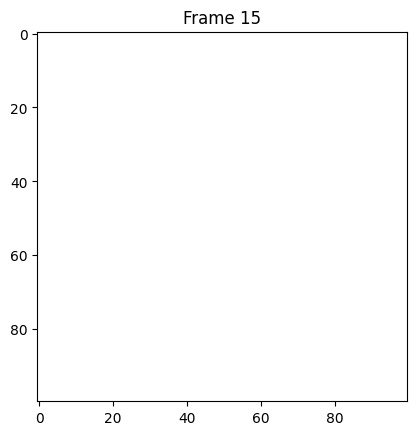

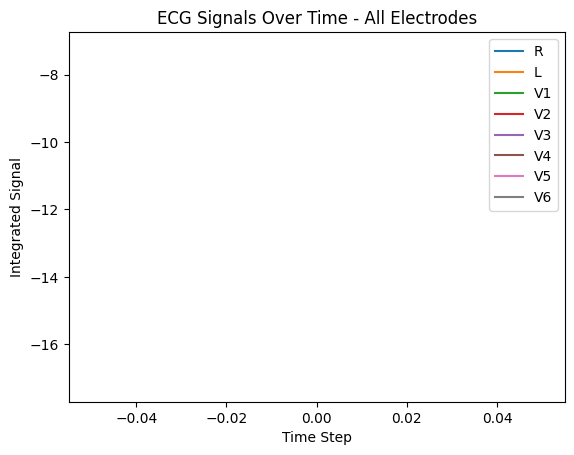

In [5]:

visualize(u_history,elec)